In [1]:
%load_ext autoreload

%autoreload 2

from __future__ import division, print_function

import cPickle as pickle
from glob import glob
import subprocess
import sys
import string
import os
import random
import numpy as np
from os.path import join
%matplotlib inline
import matplotlib
matplotlib.rc("figure", dpi=144)
import matplotlib.pyplot as plt
import tempfile

import threebody

import logging
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)
logging.debug("test")

In [2]:
name = "primary"
vlbi_parameters = ["RAJ","DECJ","PMRA","PMDEC","PX"]

In [3]:
d = join("derivative-runs",name)
params = pickle.load(open(join(d,"params.pickle"),"rb"))
F = threebody.Fitter(**params)
try:
    F.best_parameters = pickle.load(
        open(join(d,"best_parameters.pickle"),"rb"))
except IOError:
    pass
derivatives = {}
for p in F.parameters:
    derivatives[p] = np.load(join(d,"%s.npy" % p))
print("Goodness of fit:",F.goodness_of_fit())
M, linear_parameters = F.compute_linear_matrix()
lv, linear_parameters = F.compute_linear_parts()
for i, p in enumerate(linear_parameters):
    derivatives[p] = M[:,i]

parameters = F.parameters + linear_parameters
Abig = np.array([derivatives[p] 
                 for p in parameters], 
                dtype=np.longdouble).T
#print(Abig.shape)
result = threebody.lstsq_with_errors(Abig, 
                                     F.residuals(), 
                                     F.phase_uncerts)

Goodness of fit: 36705.6440017


In [4]:
fit_values = {}
for i,p in enumerate(parameters):
    if p in F.parameters:
        v = F.best_parameters[p]
    elif p in linear_parameters:
        v = lv[linear_parameters.index(p)]
    else:
        v = 0
    if p.startswith("d_") and p[2:] in vlbi_parameters:
        print(p, 
              threebody.fmt(v-result.x[i], result.uncerts[i]), 
              result.uncerts[i])
        fit_values[p[2:]] = (v - result.x[i], result.uncerts[i])

d_DECJ 4.26(19)e-5 1.85107699748e-06
d_PMDEC -1.04(11)e-8 1.14015344233e-09
d_PMRA -2.31(3)e-8 3.12266609547e-10
d_PX 2.5(7)e1 6.68382129625
d_RAJ -1.89(4)e-5 4.26815559333e-07


In [5]:
parfile_values = {}
for l in open(F.parfile,"rt").readlines():
    ps = l.split()
    if not ps:
        continue
    if ps[0] in vlbi_parameters:
        parfile_values[ps[0]] = ps[1]
for k,v in parfile_values.items():
    print(k,v)

PX 0.77
PMDEC 0
RAJ 03:37:43.82589
PMRA 0
DECJ 17:15:14.828


Values from Adam's email of 2016 Nov 28:
```
mu_a  = 5.90 +- 0.07 mas/yr  (mu_ra*cos(dec))
mu_d  = -4.02 +- 0.07 mas/yr
pi = 0.88 +- 0.06
```

## Units/scaling

What are the correct units for these derivative values? I'd like to be able to actually compute the updated values and uncertainties for each of these parameters, but that requires the correct scaling of the derivatives.

From experience these are probably "turns per _unit_", but it's not clear what _unit_ is; milliarcsecond? For the proper motion and parallax values, one could hope that _unit_ is the same unit the values are expressed in. For the position, it's harder to say. Might also be MJDs per _unit_.

The most direct way to get these is to barycenter the data with slightly modified par files, subtract the barycentered TOAs, and divide to compare to the derivative values.

In [7]:
timfile = F.files+".tim"

def bary(par, base_mjd = F.base_mjd):
    with tempfile.NamedTemporaryFile(suffix=".par") as f:
        f.write(par)
        f.flush()
        P = subprocess.Popen(["tempo2", 
                                     "-nobs", str(len(F.mjds)+100),
                                     "-npsr", "1",
                                     "-output", "general2",
                                     "-s", "OUTPUT {bat}\n",
                                     "-f", f.name,
                                     os.path.join(os.getcwd(),timfile),
                                    ],
                            stdout=subprocess.PIPE,
                            stderr=subprocess.PIPE)
        o, e = P.communicate()
        if P.returncode:
            print(o)
            print(e)
            raise ValueError
        bats = []
        for l in o.split("\n"):
            if not l.startswith("OUTPUT"):
                continue
            ls = l.split()
            bats.append(threebody.mjd_fromstring(ls[1], base_mjd))
        bats = np.array(bats, dtype = np.longdouble)
        
    return bats
    

In [8]:
par = open(F.parfile,"rt").read()
print(par)
deltas = dict(PX=0.01, PMRA=0.01, PMDEC=0.01, DECJ=0.01)
delta_r = {}

PSR              J0337+17    
RAJ      03:37:43.82589 
DECJ      17:15:14.828    
PX                    0.77
PMRA                  0
PMDEC                 0
F0    365.9533436144258189  0  0.0000000000656904
F1      7.833539631670D-15  0  1.490959143049D-17
PEPOCH        56500.000000
DM 21.315933
SOLARN0              10.00
EPHEM             DE435
CLK               TT(TAI)
TZRMJD  56100.13622674904492
TZRFRQ            1379.999
TZRSITE                  j





In [9]:
base = bary(par)

In [11]:
for k, d in deltas.items():
    if k in delta_r:
        continue
    p2 = []
    for l in par.split("\n"):
        ls = l.split()
        if ls and ls[0] == k:
            if k == "DECJ":
                dec = ls[1].split(":")
                decnew = ":".join([dec[0], dec[1], str(float(dec[2])+d)])
                nl = "%s  %s" % (k, decnew)
                print(nl)
            else:
                nl = "%s  %f" % (k, float(ls[1])+d)
        else:
            nl = l
        p2.append(nl)
    par2 = "\n".join(p2)+"\n"
    n = bary(par2)
    delta_r[k] = n-base

DECJ  17:15:14.838


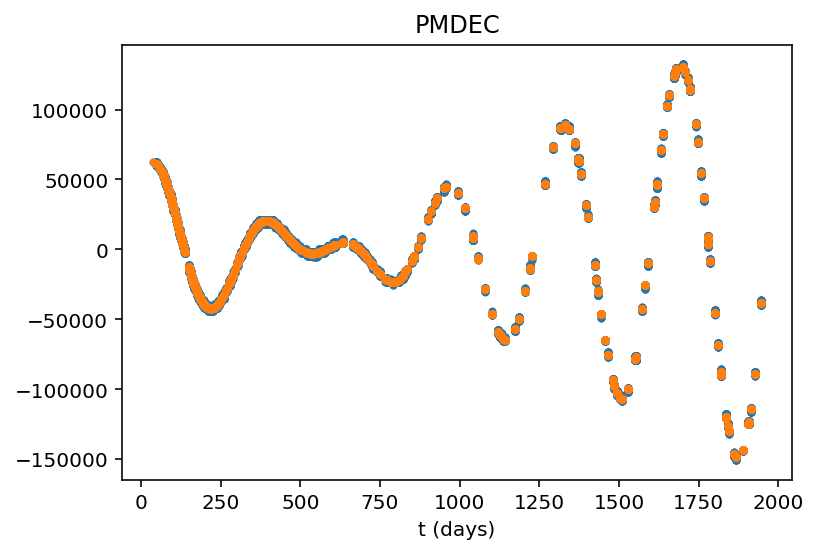

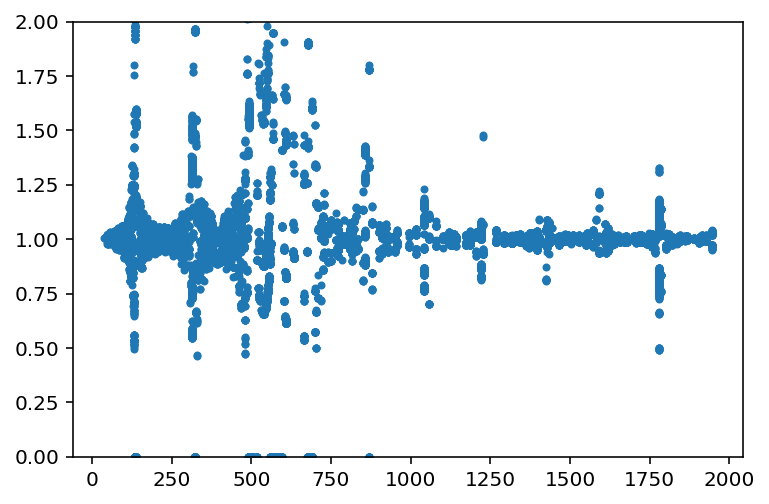

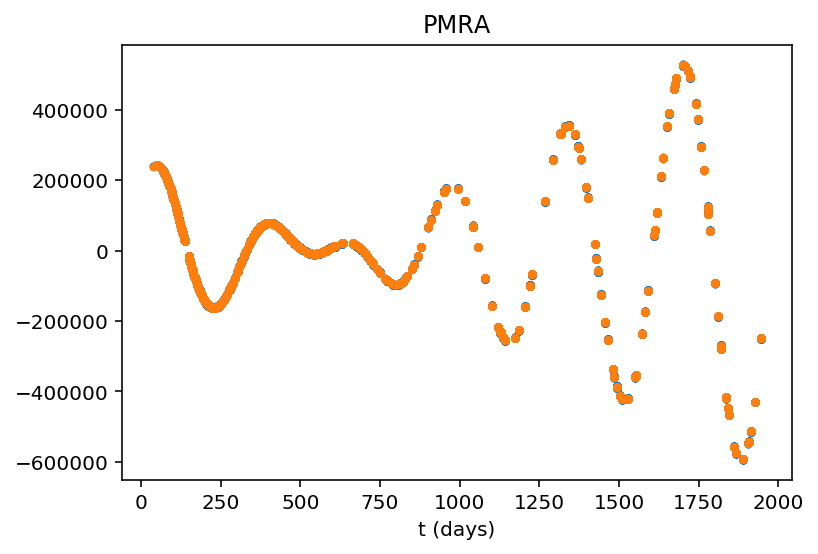

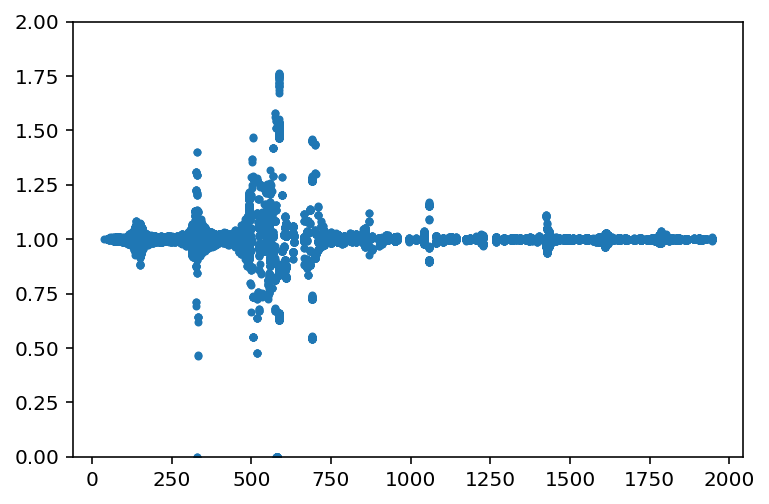

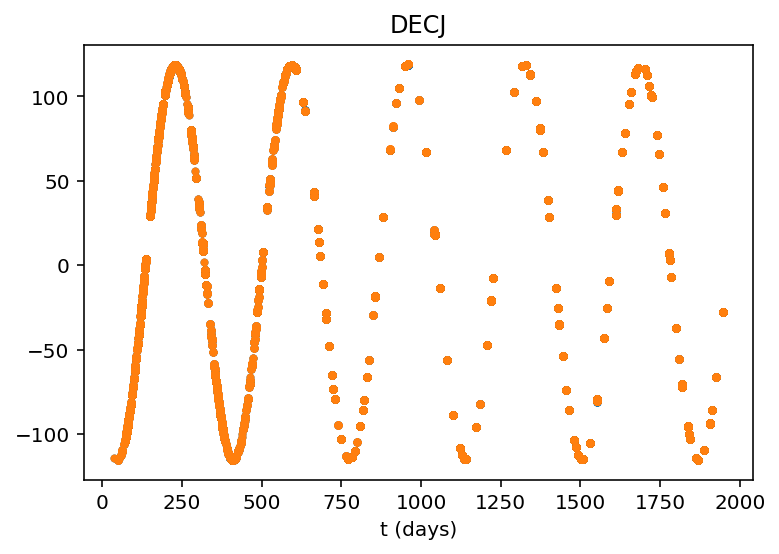

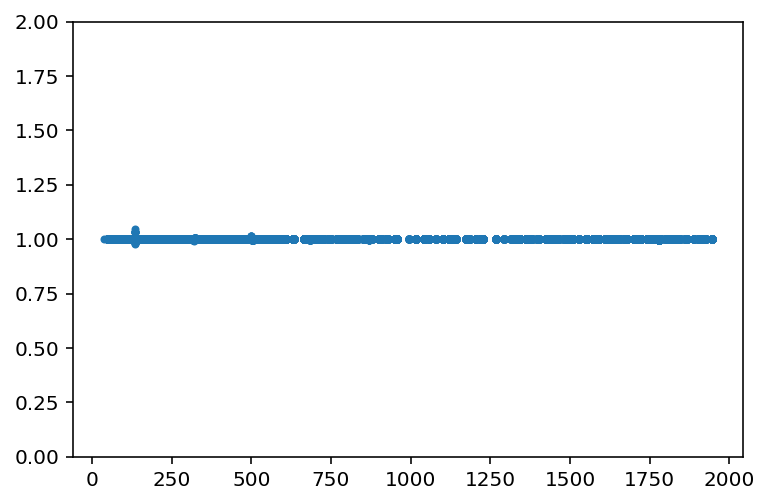

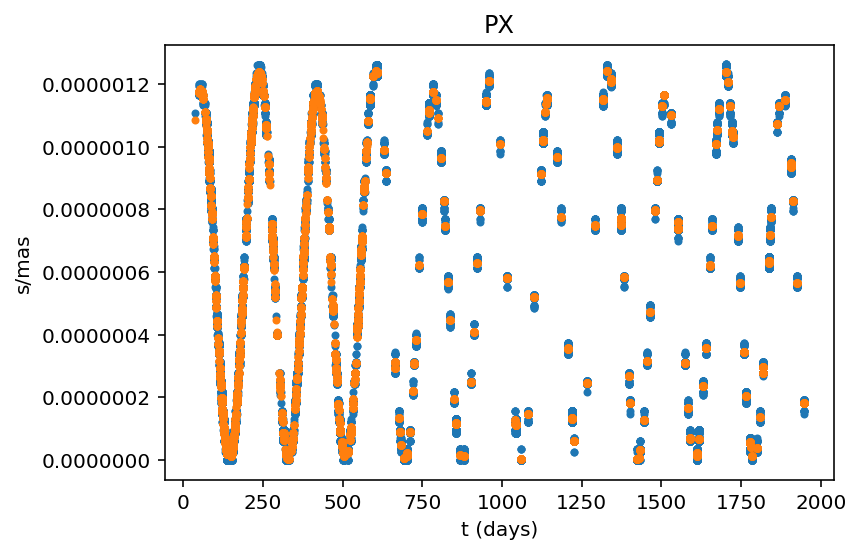

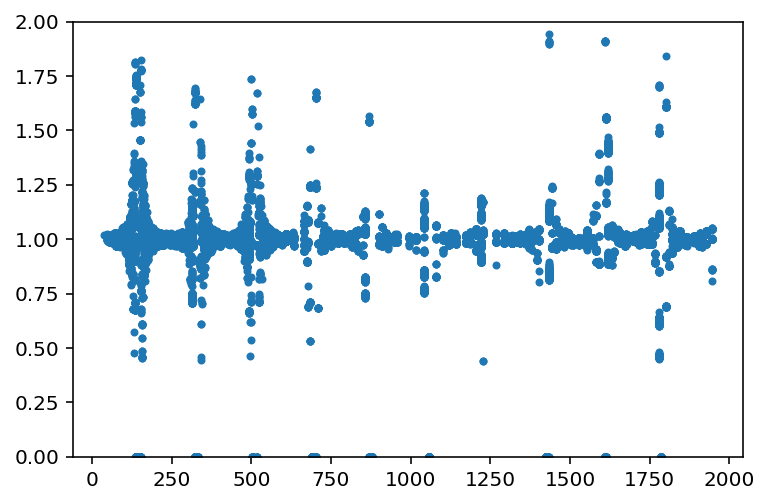

In [15]:
scales = {}
for i,k in enumerate(delta_r.keys()):
    plt.figure()
    plt.title(k)
    if k=="PX":
        scl = -86400
        plt.ylabel("s/mas")
    elif k in ["PMRA", "PMDEC"]:
        # scl = -86400*365.2425*24*60*60 # s/(mas/s)
        # scl = -86400*360*60*60*1000/(2*np.pi) # s/(rad/yr)
        scl = -86400*365.2425*360*60*60*1000/(2*np.pi) # ??
        # scl = -86400*360*360*60*60*1000/(2*np.pi) # ??
        if k == "PMRA":
            scl *= np.cos(np.deg2rad(17+15/60.))
    elif k=="DECJ":
        scl = -86400*360*60*60/(2*np.pi)     
    else:
        scl = 1
    scales[k] = scl/86400
    plt.plot(F.mjds, scl*delta_r[k]/deltas[k], ".")
    plt.plot(F.mjds, derivatives["d_"+k], ".")
    plt.xlabel("t (days)")
    plt.figure()
    plt.plot(F.mjds, scl*delta_r[k]/deltas[k]/derivatives["d_"+k], ".")
    plt.ylim(0,2)

So the units of `d_PX` are seconds per unit of parallax (milliarcsecond).

In [21]:
d_scales = dict(PX = -1/F.reference_f0,
                PMRA = -np.cos(np.deg2rad(17+15/60.))
                    *365.2425*360*60*60*1000/(2*np.pi)/F.reference_f0,
                PMDEC = -1*365.2425*360*60*60*1000/(2*np.pi)/F.reference_f0,
                DECJ = -1*360*60*60*1000/(2*np.pi)/F.reference_f0,
                RAJ = -1*360*60*60*1000/(2*np.pi)/F.reference_f0,
               )

In [22]:
for n, s in scales.items():
    print(n, s/F.reference_f0, d_scales[n])

PMDEC -205864134.409 -205864134.409
PMRA -196604354.209 -196604354.209
DECJ -563.636856087 -563636.856087
PX -0.00273258859009 -0.00273258859009


Parfile PX: 0.77 mas
Fit delta: -6.8(18)e-2 mas


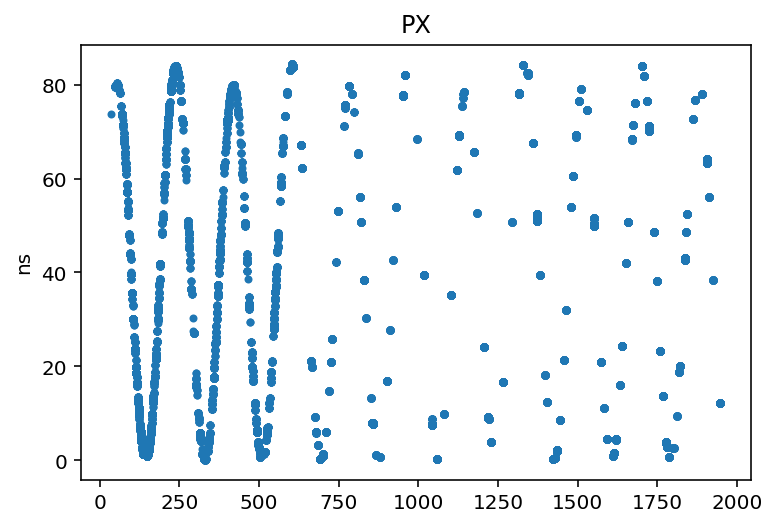

In [20]:
print("Parfile PX:", parfile_values["PX"], "mas")
dpx, dpu = fit_values["PX"]
scl = F.reference_f0**(-1)*scales["PX"]
print("Fit delta:", threebody.fmt(scl*dpx, np.abs(scl*dpu)), "mas")

plt.title("PX")
plt.plot(F.mjds, 1e9*dpx*derivatives["d_PX"]/F.reference_f0, ".")
plt.ylabel("ns")

Parfile PMRA: 0 mas/yr
Fit delta: 4.54(6)e0 mas/yr
Parfile PMDEC: 0 mas/yr
Fit delta: 2.1(2)e0 mas/yr


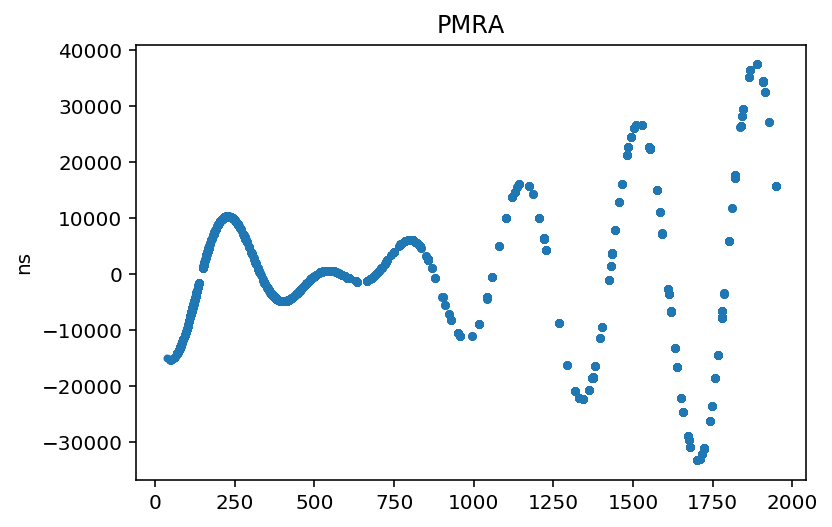

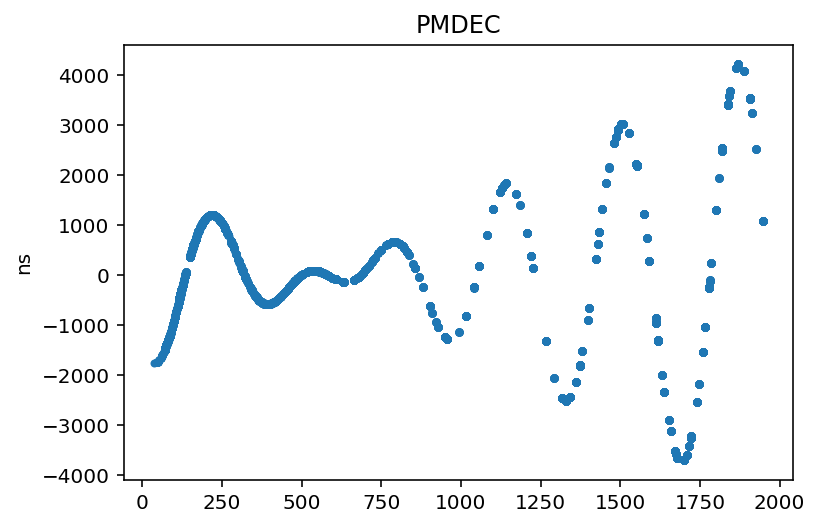

In [12]:
for n in ["PMRA","PMDEC"]:
    print("Parfile %s:" % n, parfile_values[n], "mas/yr")
    dpx, dpu = fit_values[n]
    scl = F.reference_f0**(-1)*scales[n]
    print("Fit delta:", threebody.fmt(scl*dpx, np.abs(scl*dpu)), "mas/yr")

    plt.figure()
    plt.title(n)
    plt.plot(F.mjds, 1e9*dpx*derivatives["d_"+n]/F.reference_f0, ".")
    plt.ylabel("ns")

## Timing par file

In [13]:
for l in open(F.parfile,"rt").readlines():
    if l.startswith("RAJ"):
        raj = l.split()[1]
    elif l.startswith("DEC"):
        decj = l.split()[1]
        
print(raj, decj)

03:37:43.82589 17:15:14.828
